In [18]:
#!pip install urllib3
#!pip install spacy
#!python3 -m spacy download en_core_web_sm
#!pip install nltk
#!pip install beautifulsoup4
#!pip install textacy
#!pip install feedparser

In [1]:
#Import all the necessary packages
import urllib3
from bs4 import BeautifulSoup
import spacy
from spacy import displacy
import nltk
from nltk.tokenize import RegexpTokenizer
import textacy.extract
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import feedparser
from pandas.io.json import json_normalize
import datetime
from time import sleep
import time
from random import randint
from IPython.core.display import clear_output
import warnings
import pickle

In [3]:
# Dispay images inline
%matplotlib inline

## Get the Data into the notebook

In [4]:
#Specify URL Location
url = 'https://www.infosecurity-magazine.com/blogs/remote-security-challenges-covid19/'

In [5]:
#Make a get request to the URL and print its response (status)
r = requests.get(url)
#print(r)

In [6]:
#Read in the html from the URL
html = r.text
#print(html)

## Extract data from text

In [7]:
#Create a BeautifulSoup object from the HTML and set the parser to html5lib
soup_covid = BeautifulSoup(html, "html5lib")
#type(soup)

In [8]:
#Find article title
soup_covid.title.get_text()

'\n\tRemote Workforces: Security Challenges Amid #COVID19 - Infosecurity Magazine\n'

In [9]:
#Extract text only from the paragraphs tags 
paras = soup_covid.find_all('p')

text=[]

#Loop over each paragraph tag (<p>) and get_text()
for p in paras:
    text.append(p.get_text())
#text

In [10]:
#Convert the text list object into a string so it can be tokenized
string = ' '.join(text)

In [11]:
#Create a tokenizer
tokenizer = RegexpTokenizer('\w+')

In [12]:
#Create the tokens
tokens = tokenizer.tokenize(string)
#print(tokens)

In [13]:
#Make all tokens begin with a lower case
words = []
for word in tokens:
    words.append(word.lower())
#words[:10]

In [15]:
#Create a list of enlgish stop words
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')
#sw[:10]

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
#Remove english stop words from the tokens
words_ns = []

for word in words:
    if word not in sw:
        words_ns.append(word)
        
#words_ns[:10]

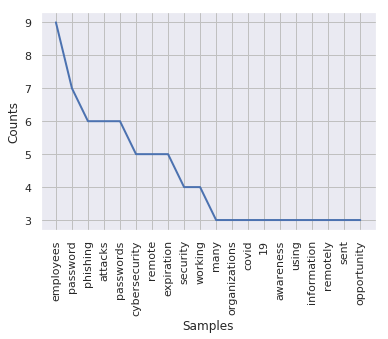

In [17]:
#Create a frequency distribution of the top 20 words

#Set the style of the plot to seaborn
sns.set()

#Use built in FreqDist function from nltk to produce a frequency distribution plot
freqdist1 = nltk.FreqDist(words_ns)
freqdist1.plot(20)


## NLP with spacy

In [19]:
#Load spacy and parse article text to 'doc'
nlp = spacy.load('en_core_web_sm')
doc = nlp(string)

In [20]:
#Create tokens 
tokens_2 = []
for token in doc:
    tokens_2.append(token.text)
#print(tokens)

In [21]:
#Load Spacy's stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [22]:
#Remove stop words from tokens
tokens_sw = []

for token in tokens_2:
    if token not in spacy_stopwords:
        tokens_sw.append(token)

#print(tokens_sw)

In [23]:
#for entity in doc.ents:
    #print(f"{entity.text} ({entity.label_})")

In [24]:
#Create a variable that extracts noun_chunks from the article
noun_chunks = textacy.extract.noun_chunks(doc, min_freq=3)

#Convert noun_chunks to all lower case strings  
noun_chunks = map(str, noun_chunks)
noun_chunks = map(str.lower, noun_chunks)

In [25]:
for noun_chunk in set(noun_chunks):
    if len(noun_chunk.split(" ")) >1:
        print(noun_chunk)

In [26]:
#Render the original text with named entities highlighted
displacy.render(doc, style='ent', jupyter=True)

## Scraping data from RSS feeds

In [27]:
#Specify RSS URL
rss_url = 'https://krebsonsecurity.com/feed/'

In [28]:
#Read RSS feed XML
news_feed = feedparser.parse(rss_url)

In [29]:
#Flatten the data
df_news_feed = json_normalize(news_feed.entries)

In [30]:
#Read in the links for individual articles from the RSS feed
df_news_feed.link.head()

0    https://krebsonsecurity.com/2020/04/sipping-fr...
1    https://krebsonsecurity.com/2020/04/covid-19-h...
2    https://krebsonsecurity.com/2020/04/microsoft-...
3    https://krebsonsecurity.com/2020/04/new-irs-si...
4    https://krebsonsecurity.com/2020/04/microsoft-...
Name: link, dtype: object

In [31]:
df_news_feed.title

0         Sipping from the Coronavirus Domain Firehose
1    COVID-19 Has United Cybersecurity Experts, But...
2          Microsoft Patch Tuesday, April 2020 Edition
3    New IRS Site Could Make it Easy for Thieves to...
4            Microsoft Buys Corp.com So Bad Guys Can’t
5    ‘War Dialing’ Tool Exposes Zoom’s Password Pro...
6    Phish of GoDaddy Employee Jeopardized Escrow.c...
7        Annual Protest to ‘Fight Krebs’ Raises €150K+
8              Russians Shut Down Huge Card Fraud Ring
9         US Government Sites Give Bad Security Advice
Name: title, dtype: object

## Scraping data straight from html pages

In [32]:
#Define the target url and create a BeautifulSoup object called 'soup'
krebs_url = 'https://krebsonsecurity.com/2014/05/experian-breach-tied-to-ny-nj-id-theft-ring/'
content = requests.get(krebs_url)
soup = BeautifulSoup(content.text, 'html.parser')

In [33]:
#Create a function that converts lists to strings
def list_to_string(l):
    str1 = ' '
    return (str1.join(l))

In [34]:
#strip back the date so it only includes numeric values
def date_stripper(d):
    x = re.findall('\d+', d)
    x_string = list_to_string(x)
    return x_string 

In [35]:
#Define a function that accepts soup objects and prints and returns a datetime object
def article_date(soup):
    
        
    #Extract the date from the page- N.B. This extraction is specific to the krebs on security page
    url_date = soup.find('p', attrs={'class':'postmetadata alt'}).get_text()
    reg_date = re.findall('on (.*?) at', url_date)
    reg_date_string = list_to_string(reg_date)
    
    reg_date_token = tokenizer.tokenize(reg_date_string)
    date = reg_date_token
    
    month_day = reg_date_token[2]
    
    date[2] = date_stripper(month_day)
    
    date_str = list_to_string(date)
    date_time_obj = datetime.datetime.strptime(date_str, '%A %B %d %Y')
    
    #return the datetime values
    return date_time_obj
    print(date_time_obj)

In [36]:
#Extract the article title from soup object 
def article_title(soup):
    article_title = soup.title.get_text()
    return article_title

In [37]:
#Extract the article body from soup object
def article_body(soup):
    article_body = soup.find_all('p') #Find paragraph tags <p>
    
    text_body = [] #initalize an empty list where the paragraphs will live
    for para in article_body:
        text_body.append(para.get_text())
    return text_body

In [38]:
article_date(soup)

datetime.datetime(2014, 5, 19, 0, 0)

In [39]:
article_title(soup)

'Experian Breach Tied to NY-NJ ID Theft Ring —  Krebs on Security'

In [40]:
article_body(soup)

['Last year, a top official from big-three credit bureau Experian told Congress that the firm was not aware of any consumers that had been harmed by an incident in which a business unit of Experian sold consumer records directly to an online identity theft service for nearly 10 months. Today’s post presents evidence that among the ID theft service’s clients was an identity theft and credit card fraud ring of at least 32 people who were arrested last year for\xa0allegedly using\xa0the information to steal millions from more \xa0than 1,000 victims across the country.',
 'Ngo’s ID theft service superget.info',
 'On March 31, 2014, 26-year-old Idris Soyemi of Brooklyn, New York pleaded guilty in a New Hampshire court to one count of wire fraud. In Soyemi’s guilty plea hearing, the prosecutor\xa0laid out how Soyemi on several occasions bought Social Security numbers, dates of birth and other personal information from an online identity theft service run by guy named Hieu Minh Ngo.',
 'Ngo i

Return the urls of every article on each page:
* Requests.get()
* Extract individual article hrefs from the <h2 class="post-title"> tag
* There are 188 pages on krebs to loop through

In [ ]:
#Define url
#krebs_url_2 = 'https://krebsonsecurity.com/page/1/'

In [ ]:
#Create BeautifulSoup object called html_soup from url
#response = requests.get(krebs_url_2)
#html_soup = BeautifulSoup(response.text, 'html.parser')

In [ ]:
#Extract the title and link of each article on the page
#article_list = html_soup.find_all('h2', {'class':'post-title'})

In [ ]:
#Create a list of links to all the articles on the page: href_list
#href_list=[]
#for article in article_list:
    #href_list.append(article.find('a').get('href'))
    
#href_list

In [44]:
#Create a list of numbers with each number corresponding to a page of the website
pages =[]
for i in range(1,187,1):
    pages.append(str(i))

In [ ]:
#Create a list of numbers with each number corresponding to a page of the website
#test_pages =[]
#for i in range(1,5):
 #   test_pages.append(str(i))

In [45]:
start_time = time.time()
num_requests = 0
href_list=[]

for page in pages:
    
    response = requests.get('https://krebsonsecurity.com/page/' + page)
    
    num_requests += 1
    sleep(randint(2,6))
    elapsed_time = time.time() - start_time
    print('Request: {}; Frequency: {} requests/s'.format(num_requests, num_requests/elapsed_time))
    clear_output(wait = True)
    
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    html_soup = BeautifulSoup(response.text, 'html.parser')
    article_list = html_soup.find_all('h2', {'class':'post-title'})
    
    #Create a list of links to all the articles on the page: href_list
    for article in article_list:
        href_list.append(article.find('a').get('href'))
    
    href_list
    

Request: 186; Frequency: 0.1742356597667361 requests/s


In [48]:
with open('href.list', 'wb') as href_list_file:
    pickle.dump(href_list, href_list_file)

In [ ]:
#list_length = len(href_list[0:10])
#for i in range(list_length):
 #   article_url = href_list[i]
  #  print(article_url)

In [49]:
start_time = time.time()
article_date_list = []
article_title_list = []
article_body_list = []
number_of_requests = 0

list_length = len(href_list)
for i in range(list_length):
    
    article_url = href_list[i]
    content = requests.get(article_url)
    
    number_of_requests += 1
    sleep(randint(1,3))
    elapsed_time = time.time() - start_time
    print('Request: {}; Frequency: {} requests/s'.format(number_of_requests, number_of_requests/elapsed_time))
    clear_output(wait=True)
    
    if content.status_code != 200:
        warn('Request: {}; Status code: {}'.format(number_of_requests, content.status_code))
    
    soup = BeautifulSoup(content.text, 'html.parser')
    
    article_date_list.append(article_date(soup))
    article_title_list.append(article_title(soup))
    article_body_list.append(article_body(soup))

    

Request: 1860; Frequency: 0.34533033120685197 requests/s


In [ ]:
#article_date_list
#article_title_list
#article_body_list

In [50]:
print(article_date_list[4], article_title_list[4], article_body_list[4])

2020-04-07 00:00:00 Microsoft Buys Corp.com So Bad Guys Can’t —  Krebs on Security ['In February, KrebsOnSecurity told the story of a private citizen auctioning off the dangerous domain corp.com for the starting price of $1.7 million. Domain experts called corp.com dangerous because years of testing showed whoever wields it would have access to an unending stream of passwords, email and other sensitive data from hundreds of thousands of Microsoft Windows PCs at major companies around the globe. This week, Microsoft Corp. agreed to buy the domain in a bid to keep it out of the hands of those who might abuse its awesome power.', '', 'Wisconsin native Mike O’Connor, who bought corp.com 26 years ago but has done very little with it since, said he hoped Microsoft would buy it because hundreds of thousands of confused Windows PCs are constantly trying to share sensitive data with corp.com. Also, early versions of Windows actually encouraged the adoption of insecure settings that made it more

In [52]:
df = pd.DataFrame({
    'Date': article_date_list,
    'Title': article_title_list,
    'Body': article_body_list
})

In [53]:
df.head()

,Date,Title,Body
0,2020-04-16,Sipping from the Coronavirus Domain Firehose —...,[Security experts are poring over thousands of...
1,2020-04-15,"COVID-19 Has United Cybersecurity Experts, But...",[The Coronavirus has prompted thousands of inf...
2,2020-04-14,"Microsoft Patch Tuesday, April 2020 Edition — ...",[Microsoft today released updates to fix 113 s...
3,2020-04-10,New IRS Site Could Make it Easy for Thieves to...,[The U.S. federal government is now in the pro...
4,2020-04-07,Microsoft Buys Corp.com So Bad Guys Can’t — K...,"[In February, KrebsOnSecurity told the story o..."


In [54]:
pickle.dump(df,open('krebs_dataset.pickle', 'wb'))

In [55]:
with open('df', 'wb') as krebs_dataset:
    pickle.dump(df, krebs_dataset)

In [56]:
df.Title

0       Sipping from the Coronavirus Domain Firehose —...
1       COVID-19 Has United Cybersecurity Experts, But...
2       Microsoft Patch Tuesday, April 2020 Edition — ...
3       New IRS Site Could Make it Easy for Thieves to...
4       Microsoft Buys Corp.com So Bad Guys Can’t —  K...
5       ‘War Dialing’ Tool Exposes Zoom’s Password Pro...
6       Phish of GoDaddy Employee Jeopardized Escrow.c...
7       Annual Protest to ‘Fight Krebs’ Raises €150K+ ...
8       Russians Shut Down Huge Card Fraud Ring —  Kre...
9       US Government Sites Give Bad Security Advice —...
10      Who’s Behind the ‘Web Listings’ Mail Scam? —  ...
11      Security Breach Disrupts Fintech Firm Finastra...
12      Zyxel Flaw Powers New Mirai IoT Botnet Strain ...
13      Coronavirus Widens the Money Mule Pool —  Kreb...
14      The Web’s Bot Containment Unit Needs Your Help...
15      Live Coronavirus Map Used to Spread Malware — ...
16      Crafty Web Skimming Domain Spoofs “https” —  K...
17      Micros